In [1]:
#  IMPORT LIB HERE
import xarray
import netCDF4
import numpy as np
import random
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.features import geometry_mask
from affine import Affine
from scipy.stats import norm,poisson, linregress
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
import requests as re
import skimage
import pickle
import heapq
from clean_line_breaks import *
%matplotlib inline

In [2]:

random.seed(0)
np.random.seed(0)

## Question 1: In the cloud(s)

In [3]:
Berkeley_lat = '37.87'
Berkeley_lon = '-122.26'
date = '2014-05-21'
my_api_key = 'DEMO_KEY'

In [4]:
base_url = 'https://api.nasa.gov/planetary/earth/imagery/'
image_query = base_url+'?lat='+Berkeley_lat+'&lon='+Berkeley_lon+'&date='+date
image_query = image_query+'&api_key='+my_api_key
print(image_query)

https://api.nasa.gov/planetary/earth/imagery/?lat=37.87&lon=-122.26&date=2014-05-21&api_key=DEMO_KEY


In [5]:
r = re.get(image_query)
r.url

'https://api.nasa.gov/planetary/earth/imagery/?lat=37.87&lon=-122.26&date=2014-05-21&api_key=DEMO_KEY'

In [6]:
r = re.get(base_url, params={'lat':Berkeley_lat,'lon':Berkeley_lon,'date':date,'api_key':my_api_key})
r.url

'https://api.nasa.gov/planetary/earth/imagery/?lat=37.87&lon=-122.26&date=2014-05-21&api_key=DEMO_KEY'

In [7]:
r.content

b'{\n  "date": "2014-05-21T18:45:34", \n  "id": "LC8_L1T_TOA/LC80440342014141LGN00", \n  "resource": {\n    "dataset": "LC8_L1T_TOA", \n    "planet": "earth"\n  }, \n  "service_version": "v1", \n  "url": "https://earthengine.googleapis.com/api/thumb?thumbid=119b0c92b83a3cf7367826555d767f48&token=4a7b590ca516a7b5dfbab0acad047cd3"\n}'

In [8]:
url = r.json()['url']
def download_file(url,local_filename):
    r = re.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    return local_filename
nasa_reply_url = r.json()['url']
download_file(nasa_reply_url,'image.png');

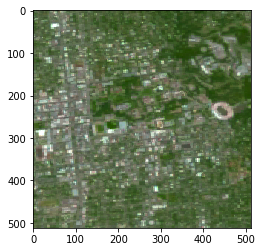

In [9]:
from skimage import io
im3 = io.imread('image.png')
plt.imshow(im3);

In [10]:
##  What is the size of the numpy arrayim?
print('array shape: ', im3.shape)
print('array size: ', im3.size)

array shape:  (512, 512, 3)
array size:  786432


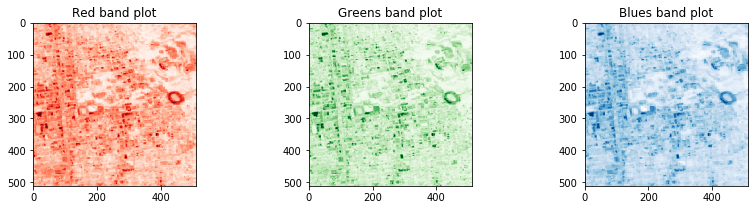

In [11]:
## plot three layers RGB
fig,(ax0,ax1,ax2) = plt.subplots(ncols = 3, figsize = (14,3))
ax0.imshow(im3[:,:,0],cmap = 'Reds')
ax0.set_title('Red band plot')
ax1.imshow(im3[:,:,1],cmap = 'Greens')
ax1.set_title('Greens band plot')
ax2.imshow(im3[:,:,2] ,cmap = 'Blues')
ax2.set_title('Blues band plot');

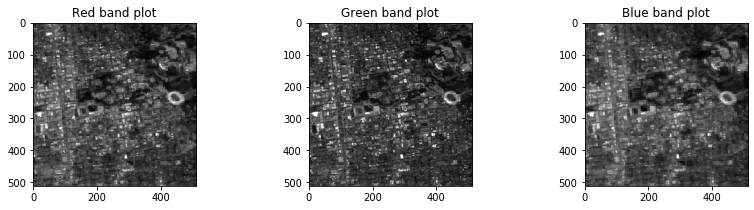

In [12]:
## plot three layers RGB
fig,(ax0,ax1,ax2) = plt.subplots(ncols = 3, figsize = (14,3))
ax0.imshow(im3[:,:,0],cmap = 'gray')
ax0.set_title('Red band plot')
ax1.imshow(im3[:,:,1],cmap = 'gray')
ax1.set_title('Green band plot')
ax2.imshow(im3[:,:,2] ,cmap = 'gray')
ax2.set_title('Blue band plot');

#### Is it easy to tell them apart?
It is not easy to tell them apart but we notice that the blue and red band images are more blury whereas the green band is more sharp.


### Expanding image area:
Request one image directly south and the two images directly north of the first image and concatenate (i.e.  tile)  them to make an image that is four times larger in terms of its coverage.

In [13]:
## request and create all three images( 1 south and 2 north)
for i in range(3):
    Berkeley_lat = ['37.845','37.895','37.92']
    Berkeley_lon = '-122.26'
    date = '2014-05-21'
    base_url = 'https://api.nasa.gov/planetary/earth/imagery/'
    image_query = base_url+'?lat='+Berkeley_lat[i]+'&lon='+Berkeley_lon+'&date='+date
    image_query = image_query+'&api_key='+my_api_key
    r_s = re.get(image_query)
    url_s = r_s.json()['url']
    download_file(url_s,'image{}.png'.format(i+2));

In [14]:
## read new images
im4 = io.imread('image2.png')
im1 = io.imread('image3.png')
im2 = io.imread('image4.png')


In [15]:
## concat list 4 images
im_list = [im2,im1,im3,im4]
#im_full = io.concatenate_images(im_list)
im_f = np.vstack(im_list)
# im_f =[]
# for i in range(3):
#     im_f.append(np.concatenate((im[:,:,i],im2[:,:,i],im3[:,:,i],im4[:,:,i])))
                   
# im_f = np.array(im_f)
# im_f = im_f.reshape(2048,512,3)
im_f.shape
    

(2048, 512, 3)

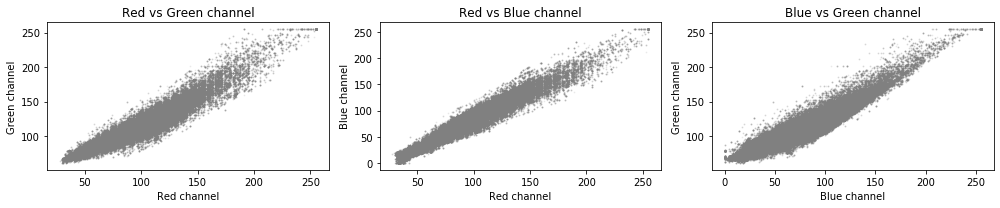

In [16]:
## plot the red channel vs.  green channel values for each pixel separately with the command
fig,(ax0,ax1,ax2) = plt.subplots(ncols = 3, figsize = (14,3))
ax0.scatter(im3[:,:,0].flatten(), im3[:,:,1].flatten(),color = 'gray',alpha=0.1,s=1);
ax0.set_xlabel('Red channel')
ax0.set_ylabel('Green channel')
ax0.set_title('Red vs Green channel')
ax1.scatter(im3[:,:,0].flatten(), im3[:,:,2].flatten(),color = 'gray',alpha=0.1,s=1);
ax1.set_xlabel('Red channel')
ax1.set_ylabel('Blue channel')
ax1.set_title('Red vs Blue channel')
ax2.scatter(im3[:,:,2].flatten(), im3[:,:,1].flatten(),color = 'gray',alpha=0.1,s=1);
ax2.set_xlabel('Blue channel')
ax2.set_ylabel('Green channel')
ax2.set_title('Blue vs Green channel')
fig.tight_layout();

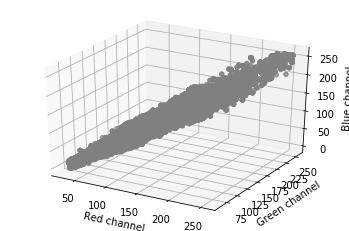

In [17]:
## Plotting in 3D
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(im3[:,:,0], im3[:,:,1], im3[:,:,2], c='gray', marker='o')

ax.set_xlabel('Red channel')
ax.set_zlabel('Blue channel')
ax.set_ylabel('Green channel')

plt.show()

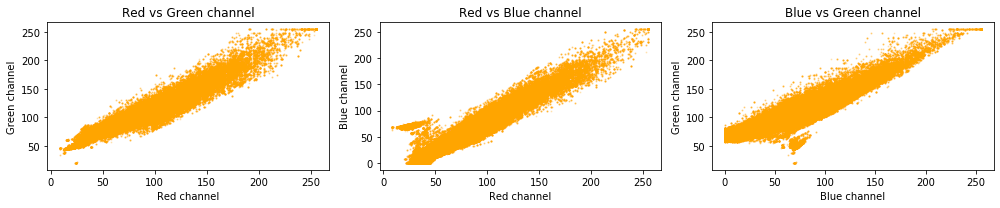

In [18]:
## plot the red channel vs.  green channel values for each pixel separately with the command for full image
fig,(ax0,ax1,ax2) = plt.subplots(ncols = 3, figsize = (14,3))
ax0.scatter(im_f[:,:,0].flatten(), im_f[:,:,1].flatten(),color = 'orange',alpha=0.2,s=1);
ax0.set_xlabel('Red channel')
ax0.set_ylabel('Green channel')
ax0.set_title('Red vs Green channel')
ax1.scatter(im_f[:,:,0].flatten(), im_f[:,:,2].flatten(),color = 'orange',alpha=0.2,s=1);
ax1.set_xlabel('Red channel')
ax1.set_ylabel('Blue channel')
ax1.set_title('Red vs Blue channel')
ax2.scatter(im_f[:,:,2].flatten(), im_f[:,:,1].flatten(),color = 'orange',alpha=0.2,s=1);
ax2.set_xlabel('Blue channel')
ax2.set_ylabel('Green channel')
ax2.set_title('Blue vs Green channel')
fig.tight_layout();

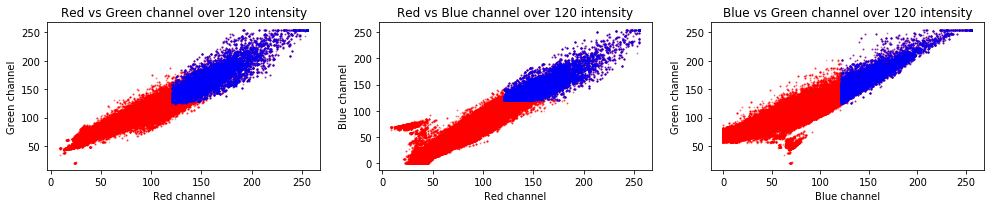

In [19]:
## plotting for full images only aregions with intensities above 120
red_over = im_f[:,:,0][(im_f[:,:,0]>120) & (im_f[:,:,1]>120) & (im_f[:,:,2]>120)]
green_over = im_f[:,:,1][(im_f[:,:,0]>120) & (im_f[:,:,1]>120) & (im_f[:,:,2]>120)]
blue_over = im_f[:,:,2][(im_f[:,:,0]>120) & (im_f[:,:,1]>120) & (im_f[:,:,2]>120)]

## plot the red channel vs.  green channel values for each pixel separately with the command for full image
fig,(ax0,ax1,ax2) = plt.subplots(ncols = 3, figsize = (14,3))
ax0.scatter(im_f[:,:,0].flatten(), im_f[:,:,1].flatten(),color = 'red',alpha=0.2,s=1);
ax0.scatter(red_over.flatten(), green_over.flatten(),color = 'b',alpha=0.2,s=1);
ax0.set_xlabel('Red channel')
ax0.set_ylabel('Green channel')
ax0.set_title('Red vs Green channel over 120 intensity')
ax1.scatter(im_f[:,:,0].flatten(), im_f[:,:,2].flatten(),color = 'red',alpha=0.2,s=1);
ax1.scatter(red_over.flatten(), blue_over.flatten(),color = 'b',alpha=0.2,s=1);
ax1.set_xlabel('Red channel')
ax1.set_ylabel('Blue channel')
ax1.set_title('Red vs Blue channel over 120 intensity')
ax2.scatter(im_f[:,:,2].flatten(), im_f[:,:,1].flatten(),color = 'red',alpha=0.2,s=1)
ax2.scatter(blue_over.flatten(), green_over.flatten(),color = 'b',alpha=0.2,s=1);
ax2.set_xlabel('Blue channel')
ax2.set_ylabel('Green channel')
ax2.set_title('Blue vs Green channel over 120 intensity')
fig.tight_layout();

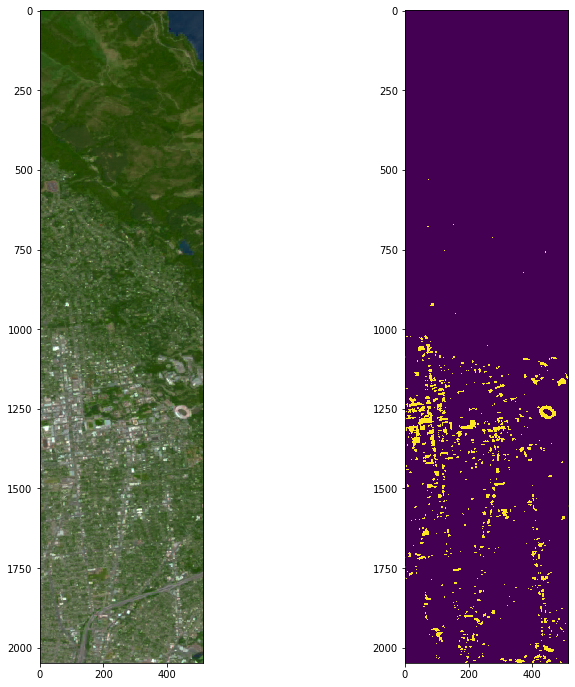

In [20]:
mask =  im_f >120
type(mask)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(im_f);  
plt.subplot(122)
for i in range(3):
    plt.imshow(mask[:,:,i])

The bright color mask does a relatively good job caputing the images on different bulding as seen from the comparison between the 2 images in the previous plot. 

## Question 2:  How many cats could a camera catch if a camera could catchcats?

## function for 1 snow leopard
move_one_step(position) -->  movement in one step for single snow leopard

simulations(position,timestep=1) --> simullates movement over multiple time steps

In [21]:
# function that computes movement in each time step
def move_one_step(position): #position(1x2 list)
        temp_x= position[0] +  np.random.randint(-1,high=2)
        temp_y= position[1] +  np.random.randint(-1,high=2)
        
        check = False
        while not check:
            if (temp_x == position[0]) and (temp_y == position[1]):
                temp_x= position[0] +  np.random.randint(-1,high=2)
                temp_y= position[1] +  np.random.randint(-1,high=2)
            if temp_x>9 or temp_x<0 or temp_y>9 or temp_y<0 :
                temp_x= position[0] +  np.random.randint(-1,high=2)
                temp_y= position[1] +  np.random.randint(-1,high=2)
            if temp_x<=9 and temp_x>=0 and temp_y<=9 and temp_y>=0 :
                check = True
        
        return [temp_x,temp_y]

# Function that simulates the single leopard movement
def simulations(position,timestep=1):
    path = []
    pos = move_one_step(position)
    for i in range(timestep):
        #ipath = []
        
        path.append(pos)
        pos = move_one_step(pos)
    #print(path)
    return np.array(path)
        
        

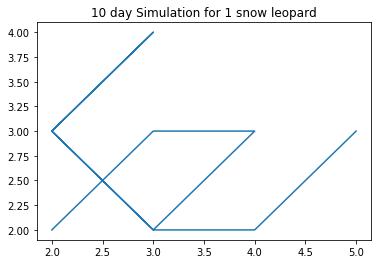

In [25]:
path = simulations([random.randint(0,9),random.randint(0,9)],timestep=10)
# path = simulations([1,1],timestep=10)
path.shape
## plot path
#print(path)
plt.plot(path[:,0],path[:,1])
plt.title('10 day Simulation for 1 snow leopard');




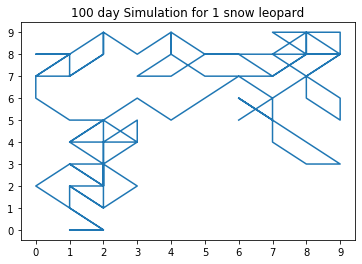

In [26]:
#Run your code for 100 days and make a plot of the snow leopard’s path in the 10km x 10 km space over the entire study.
path_100 = simulations([random.randint(0,9),random.randint(0,9)],timestep=100)
path_100.shape
## plot path

plt.plot(path_100[:,0],path_100[:,1])
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Simulation for 1 snow leopard');

## Function for Multiple Snow Leopards
move_one_step_(position) -->  movement in one step for  multiple snow leopard


simulations_(position,timestep=1) --> simulates movement over multiple time steps

In [27]:
## For higher dimensions, multiple leopards
def move_one_step_(position):
    temp =[]
    for i in range(0,len(position),2):
        #print(i)
        #temp= position[i,:] +  np.random.randint(-1,high=1, size=(1, 2))
        temp_x= position[i] +  np.random.randint(-1,high=2)
        temp_y= position[i+1]+  np.random.randint(-1,high=2)
        check = False
        while not check:
            if temp_x>9 or temp_x<0 or temp_y>9 or temp_y<0 :
    #             temp_x= position[i][0] +  np.random.randint(-1,high=2)
    #             temp_y= position[i][1] +  np.random.randint(-1,high=2)
                temp_x= position[i] +  np.random.randint(-1,high=2)
                temp_y= position[i+1]+  np.random.randint(-1,high=2)
            if (temp_x == position[i]) and (temp_y == position[i+1]):
                temp_x= position[i] +  np.random.randint(-1,high=2)
                temp_y= position[i+1]+  np.random.randint(-1,high=2)
            if temp_x<=9 and temp_x>=0 and temp_y<=9 and temp_y>=0 :
                    check = True
        temp.append(temp_x)
        temp.append(temp_y)
       # temp.append([temp_x,temp_y])
    return temp
## For higher dimensions, multiple leopards
def simulations_(position,timestep=1):
    path = []
#     for i in range(timestep):
#         #ipath = []
#         pos = move_one_step_(position)
#         path.append(pos)
#         #print(path)
    pos = move_one_step_(position)
    for i in range(timestep):
        path.append(pos)
        pos = move_one_step_(pos)
        #print(type(pos))
        #print(pos)
    return np.array(path)
        
        

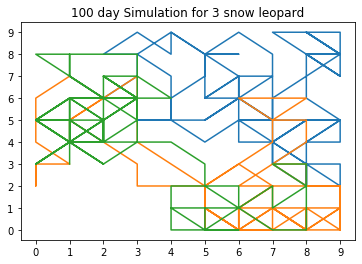

In [28]:
position1 = [random.randint(0,9),random.randint(0,9),random.randint(0,9),random.randint(0,9),random.randint(0,9),random.randint(0,9)]
# test = move_one_step_(position1)
# test
path1 = simulations_(position1,timestep=100)
# # path = simulations([1,1],timestep=10)
#path1
# plot path
#print(path)
## master plot with all three paths
plt.plot(path1[:,0],path1[:,1])
plt.plot(path1[:,2],path1[:,3])
plt.plot(path1[:,4],path1[:,5])
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Simulation for 3 snow leopard');

        

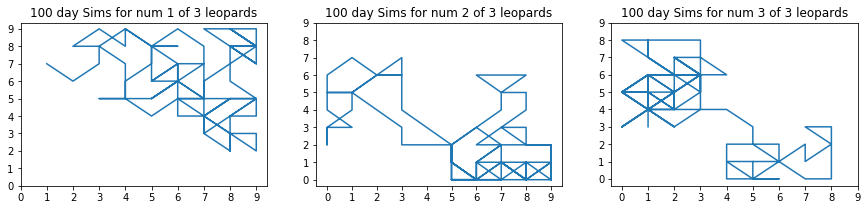

In [31]:
#subplots with paths of three animals
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(path1[:,0],path1[:,1])
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Sims for num 1 of 3 leopards');
plt.subplot(1,3,2)
plt.plot(path1[:,2],path1[:,3])
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Sims for num 2 of 3 leopards');
plt.subplot(1,3,3)
plt.plot(path1[:,4],path1[:,5])
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Sims for num 3 of 3 leopards');






## Setting up Camera simulations for multiple snow leopards

In [32]:
def simulations_cam(position,cam_pos = [3,3],timestep=1):
    path = []
    clist = []
    on = 0
    on_list =[]
    #counter =0
    # check if any animal initialized on camera cell
    for i in range(0,len(position),2):
        if (position[i] == cam_pos[0]) and (position[i+1] == cam_pos[1]):
            on = on + 1
    on_list.append(on)
    if on > 0:
        clist.append(1) 
    else:
        clist.append(0) 
        
    ## check for simulation steps
   
    on = 0    
    pos = move_one_step_(position)
    for j in range(timestep):
        path.append(pos)
        for i in range(0,len(position),2):
            if (pos[i] == cam_pos[0]) and (pos[i+1] == cam_pos[1]):
                    on = on + 1   
        on_list.append(on)
        if on > 0:
            clist.append(1) 
        else:
            clist.append(0)
        pos = move_one_step_(pos)
        on = 0
    #path.append(position)
#     print(len(path))
#     print(len(clist))
    return np.array(path), clist,on_list
  
        


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


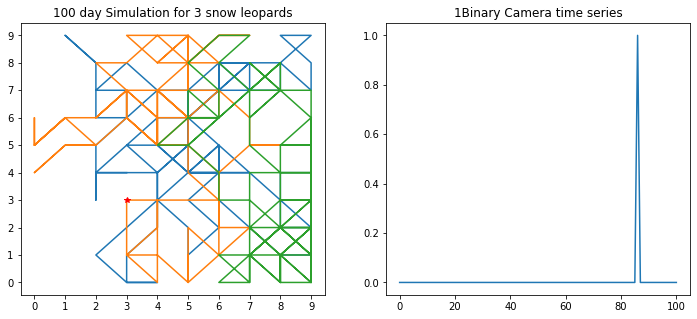

In [33]:
## simulation for three animals
## specify a position list with 6 values [x1,y1,x2,y2,x3,y3]
position = [random.randint(0,9),random.randint(0,9),random.randint(0,9),
            random.randint(0,9),random.randint(0,9),random.randint(0,9)]
path = simulations_cam(position,[3,3],timestep=100)

# # ## master plot with all three paths
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(path[0][:,0],path[0][:,1])
plt.plot(path[0][:,2],path[0][:,3])
plt.plot(path[0][:,4],path[0][:,5])
plt.plot([3],[3],'r*')
plt.xticks(np.arange(0, 10, step=1));
plt.yticks(np.arange(0, 10, step=1));
plt.title('100 day Simulation for 3 snow leopards');
plt.subplot(1,2,2)
plt.plot(path[1]);
plt.title('1Binary Camera time series');
print(path[2]);
        

## Monte Carlo Simulation

In [34]:
N_bar = 1 ## implies 1 animal
position = [random.randint(0,9),random.randint(0,9)]*N_bar
M_list = []
for i in range(1000):
    result = simulations_cam(position, timestep=100)
    M= np.array(result[1]).sum()
    M_list.append(M)



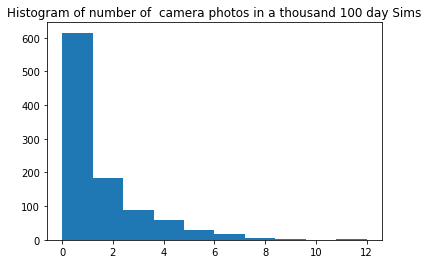

In [35]:
## Prob(M= 5|N=N′)
plt.hist(M_list)
plt.title('Histogram of number of  camera photos in a thousand 100 day Sims');

# hist,bins = np.histogram(M_list) 
# #print('Prob(M= 5|N=N′) :' ,hist[4] )
# hist

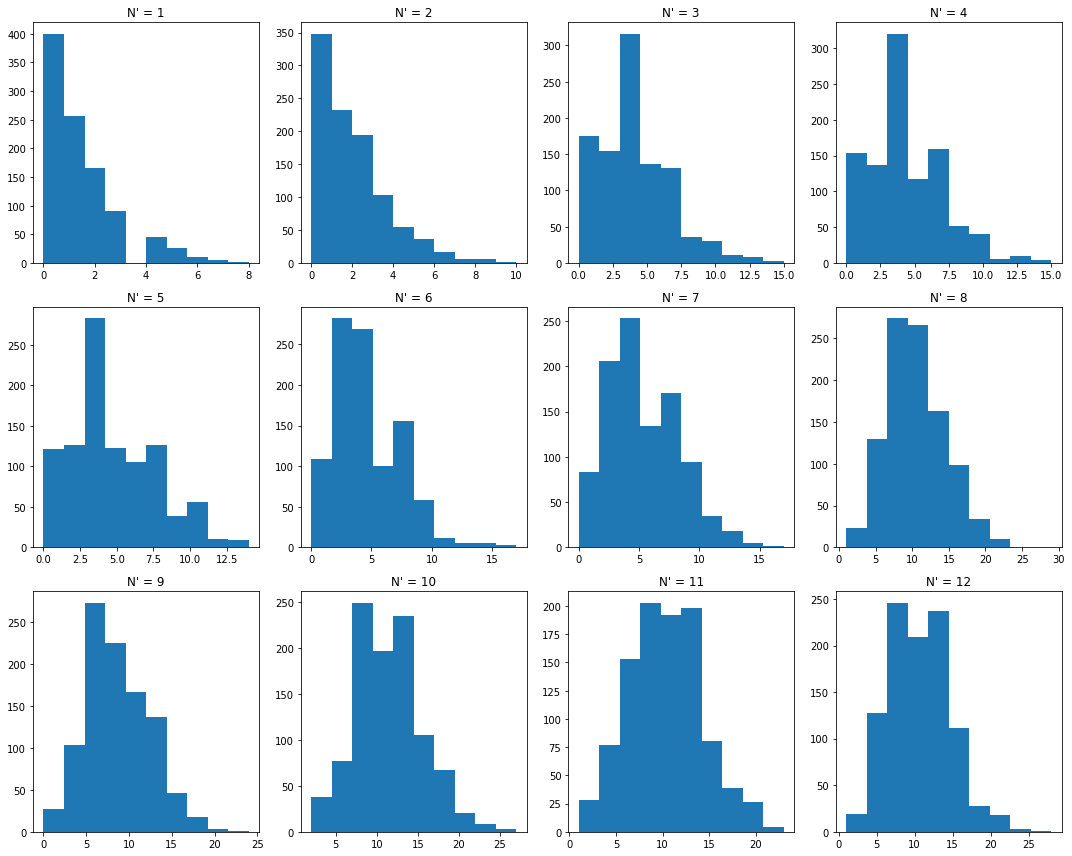

In [36]:
fig = plt.figure(figsize=(15,12))
for i in range(1,13):
    position = [random.randint(0,9),random.randint(0,9)]*i
    M_list = []
    for j in range(1000):
        result = simulations_cam(position, timestep=100)
        M= np.array(result[1]).sum()
        M_list.append(M)
        
    ## Prob(M= 5|N=N′)
    plt.subplot(3,4,i)
    plt.hist(M_list)
    plt.title('N\' = {}'.format(i))
    

plt.tight_layout()


### Estimating the most likely number of snow leopards

In [40]:
prob_list = []
for i in range(12):
    position = [random.randint(0,9),random.randint(0,9)]*(i+1)
    M_list = []
    # run 1000 simulations for N=1 to N=12
    for j in range(1000):
        result = simulations_cam(position, timestep=100)
        M= np.array(result[1]).sum()
        
        M_list.append(M)
    #print(M_list)
    count = 0
    ## count the number of times recordings = 5
    ## check if there are five recordings and count number of times it occurs
    for k in M_list:
        if k==5:
            count+=1
    #print(count)
    prob_list.append(count);    

In [41]:
prob_list

[8, 44, 101, 104, 115, 63, 30, 29, 98, 52, 4, 2]

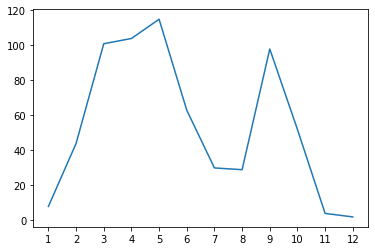

In [42]:
## plot prob
plt.plot( [1,2,3,4,5,6,7,8,9,10,11,12], prob_list)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12]);


### To do answer  what is Most likely number of leopard
Most likely number of leopards is 5 since it have the highest freqency of occurrence in this case

## Sensitivity Analysis : Moving Camera location

In [43]:
N_bar = 3  ## implies 3 animal
## Creates a list with six elements [x1,y1,x2,y2,x3,y3]
position = [random.randint(0,9),random.randint(0,9)] *N_bar 
M_list = []
camera_pos = [[3,3],[1,1],[5,5]]
var_M =[]
for cam in camera_pos:
    for i in range(1000):
        result = simulations_cam(position,cam_pos=cam, timestep=100)
        M= np.array(result[1]).sum()
        M_list.append(M)
    var_M.append(np.var(M_list))



In [44]:
var_M = np.array(var_M)
var_M

array([5.061479  , 6.926196  , 6.14125156])

In [45]:
var_M ==np.max(var_M) ## tells us max value is at position 2 of camera position list above

array([False,  True, False])

The location [1,1] produces an M distribution with the largest variance. This means that the probability of having 5 images (M=5) given an N_bar varies wildly between simulations. This implies that the camera position is the most volatile and may be more susceptible to noise in the recordings
I will place my camera at [3,3] as originally designed because it has the smallest variance on its M - distribution and as such it is more robust to noise in the system

## Question 3: As the crow flies and as the railcar rolls...

In [46]:
df = gpd.read_file('ZAF_rails.shp')

In [47]:
df.head()

,FID_rail_d,F_CODE_DES,EXS_DESCRI,FCO_DESCRI,FID_countr,ISO,ISOCOUNTRY,geometry
0,178669,Railroad,Operational,Single,241,ZAF,SOUTH AFRICA,LINESTRING (29.99286492299999 -22.225237264526...
1,179472,Railroad,Operational,Single,241,ZAF,SOUTH AFRICA,LINESTRING (29.93021387999999 -23.493394945526...
2,179664,Railroad,Operational,Single,241,ZAF,SOUTH AFRICA,LINESTRING (30.77216522099999 -24.047384185526...
3,179730,Railroad,Operational,Single,241,ZAF,SOUTH AFRICA,LINESTRING (30.77216522099999 -24.047384185526...
4,179822,Railroad,Operational,Single,241,ZAF,SOUTH AFRICA,LINESTRING (28.11953547899999 -24.292474660526...


In [48]:
df.shape

(497, 8)

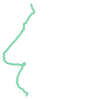

In [49]:
df['geometry'][0]

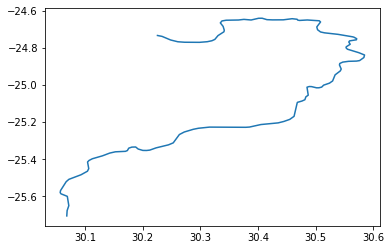

In [50]:
i = 10
plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])

In [51]:
## cleaning data
from clean_line_breaks import clean_line_breaks
df = clean_line_breaks(df)

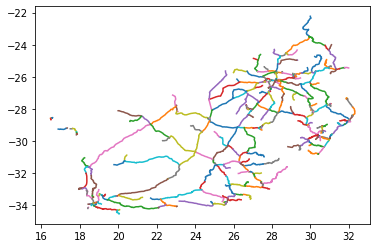

In [52]:
for i in range(len(df['geometry'])):
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])

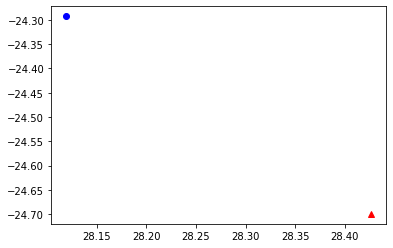

In [53]:
## plotting the station at the start of the fifth link as a closed blue circle 
line_lats, line_lons = df['geometry'][4].xy
plt.plot(line_lats[0],line_lons[0], color='blue', marker='o')
## plotting the station at the end of the fifth link as a red triangle (
plt.plot(line_lats[-1],line_lons[-1], color='red', marker='^')

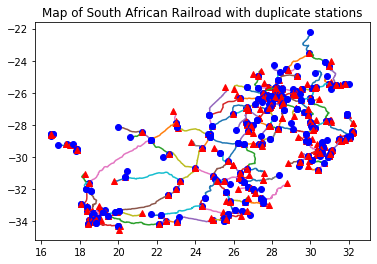

In [61]:
for i in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])
    plt.plot(line_lats[0],line_lons[0], color='blue', marker='o')
    plt.plot(line_lats[-1],line_lons[-1], color='red', marker='^')
plt.title('Map of South African Railroad with duplicate stations');

In [55]:
## Creating a list (which may include duplicates) of all start and end stations
start_lats, start_lons = [], []
end_lats, end_lons = [], []
for i in range(len(df)):
    line_lats, line_lons = df['geometry'][i].xy
    start_lats.append(line_lats[0])
    start_lons.append(line_lons[0])
    end_lats.append(line_lats[-1])
    end_lons.append(line_lons[-1])
## create stacked list with duplicates    
list_with_duplicates = np.array(list(zip(start_lats+end_lats, start_lons+end_lons)))


In [56]:
## pull out unique stations
stations = np.unique(list_with_duplicates, axis=0)



number of uniques stations:  457


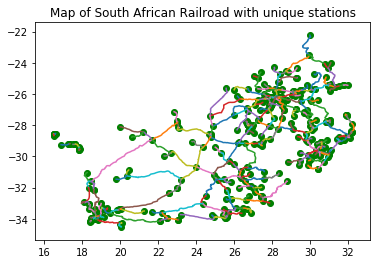

In [63]:
for i in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])
plt.scatter(stations[:,0],stations[:,1], color = 'g')#,alpha = 0.5)
plt.title('Map of South African Railroad with unique stations')
## check number or stations
print('number of uniques stations: ',stations.shape[0])

In [58]:
## create the adjacency matrix
L = np.zeros((len(stations),len(stations)))
for i in range(len(df)):  ### index of link
    line_lats, line_lons = df['geometry'][i].xy
    for j in range(len(stations)):  ### index of node
        if np.sum([line_lats[0], line_lons[0]] == stations[j,:])  == 2:
            start_j = j
        if np.sum([line_lats[-1], line_lons[-1]] == stations[j,:])  == 2:
            end_j = j
    L[start_j,end_j] = 1
    L[end_j,start_j] = 1
    



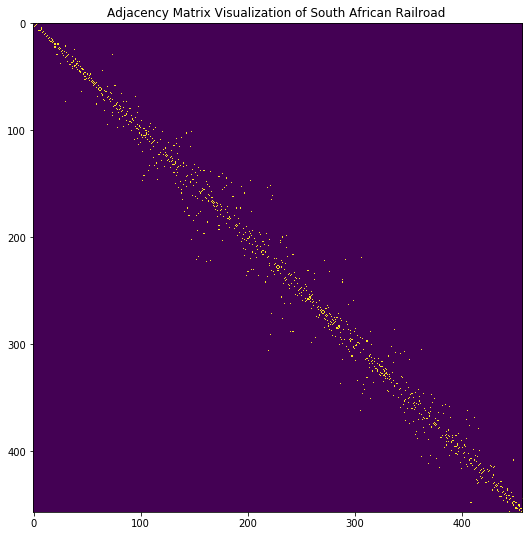

In [66]:
## plot the adjacency matrix
plt.figure(figsize=(9,9))
plt.imshow(L);
plt.title('Adjacency Matrix Visualization of South African Railroad ');

In [67]:
## computing distance in degrees
def dist(line_lats, line_lons):
    distance = 0
    for i in range(len(line_lats)-1):
        distance += np.sqrt((line_lats[i]- line_lats[i+1]) ** 2 + (line_lons[i] - line_lons[i+1]) ** 2)
    return distance
    

In [68]:
## create the distance matrix,D

D = np.empty((len(stations), len(stations)))
D[:] = np.nan
for i in range(len(df)):  ### index of link
    line_lats, line_lons = df['geometry'][i].xy
    for j in range(len(stations)):  ### index of node
        if np.sum([line_lats[0], line_lons[0]] == stations[j,:])  == 2:
            start_j = j
        if np.sum([line_lats[-1], line_lons[-1]] == stations[j,:])  == 2:
            end_j = j
    D[start_j,end_j] = dist(line_lats, line_lons)
    D[end_j,start_j] = dist(line_lats, line_lons)
## Saving as a pickle file    
with open('distance_matrix.pickle', 'wb') as handle:
    pickle.dump(D, handle)


In [69]:
with open('distance_matrix.pickle', 'rb') as handle:
    D = pickle.load(handle)


In [70]:
D[:5,:5]

array([[0.00000000e+00,            nan, 2.24990204e-02,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
        5.98037875e-02],
       [2.24990204e-02,            nan,            nan, 1.00000000e-04,
                   nan],
       [           nan,            nan, 1.00000000e-04,            nan,
                   nan],
       [           nan, 5.98037875e-02,            nan,            nan,
                   nan]])

In [71]:
L[:5,:5]

array([[1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]])

Text(0.5, 1.0, 'Distance Matrix Visualization of South African Railroad ')

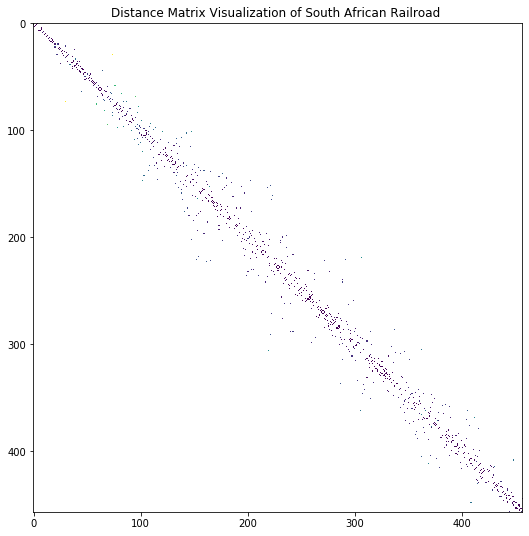

In [73]:
## visualize distance  matrix
plt.figure(figsize=(9,9))
plt.imshow(D);
plt.title('Distance Matrix Visualization of South African Railroad ')

In [74]:
## convert distance matrix to adjacency distance  list
from collections import defaultdict
from pprint import pprint


graph = defaultdict(dict)
edges =[]
for i, v in enumerate(D, 0):
    for j, u in enumerate(v, 0):
        if (not np.isnan(u)) and ((i, j) not in edges):
            edges.append((i, j))
            graph[i][j] =u

In [75]:
pprint(graph)


defaultdict(<class 'dict'>,
            {0: {0: 0.0, 2: 0.02249902042535192},
             1: {4: 0.05980378749946118},
             2: {0: 0.02249902042535192, 3: 9.999999999976694e-05},
             3: {2: 9.999999999976694e-05},
             4: {1: 0.05980378749946118},
             5: {7: 0.07709904136696218},
             6: {7: 0.026658368247431858},
             7: {5: 0.07709904136696218, 6: 0.026658368247431858},
             8: {9: 0.41559193695028224},
             9: {8: 0.41559193695028224},
             10: {11: 0.04704616844979834},
             11: {10: 0.04704616844979834},
             12: {13: 0.10134550338768951},
             13: {12: 0.10134550338768951},
             14: {15: 0.33744624400674744},
             15: {14: 0.33744624400674744, 17: 0.07648606380268454},
             16: {18: 0.05007703162498846},
             17: {15: 0.07648606380268454, 18: 0.08959386231070998},
             18: {16: 0.05007703162498846,
                  17: 0.08959386231070998,
  

                   313: 0.04814863399493369,
                   331: 0.17502506261783055},
             312: {315: 0.14249692905490224},
             313: {311: 0.04814863399493369,
                   318: 0.1008165331641194,
                   322: 0.08422446237591433},
             314: {288: 0.9202761668456811,
                   310: 0.45865528234908276,
                   351: 0.8678250999236367},
             315: {300: 0.6188596149560239,
                   312: 0.14249692905490224,
                   316: 0.01720726590716736},
             316: {315: 0.01720726590716736,
                   318: 0.04276999603659745,
                   325: 0.05378369447446665},
             317: {336: 0.5989870798387429},
             318: {313: 0.1008165331641194,
                   316: 0.04276999603659745,
                   321: 0.02355525419094467},
             319: {323: 0.027507809833936196},
             320: {323: 0.047209501812171},
             321: {318: 0.02355525419094467,
       

### Dijkstra’s  Algorithm - outputting shortest path to all points from starting point

In [76]:
def calculate_distances(graph, starting_vertex,end_vertex=None):
    distances = {vertex: float('infinity') for vertex in graph}
    distances[starting_vertex] = 0

    pq = [(0, starting_vertex)]
    visited = []
    while len(pq) > 0:
        current_distance, current_vertex = heapq.heappop(pq)
        #print(current_distance, current_vertex)

        # Nodes can get added to the priority queue multiple times. We only
        # process a vertex the first time we remove it from the priority queue.
        if current_distance > distances[current_vertex]:
            continue

        for neighbor, weight in graph[current_vertex].items():
            distance = current_distance + weight

            # Only consider this new path if it's better than any path we've
            # already found.
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                heapq.heappush(pq, (distance, neighbor))
    #print(distances[end_vertex])
    return distances

In [77]:
starting_vertex =20
calculate_distances(graph, starting_vertex)

{0: inf,
 1: inf,
 2: inf,
 3: inf,
 4: inf,
 5: inf,
 6: inf,
 7: inf,
 8: inf,
 9: inf,
 10: inf,
 11: inf,
 12: inf,
 13: inf,
 14: inf,
 15: inf,
 16: inf,
 17: inf,
 18: inf,
 19: inf,
 20: 0,
 21: 2.5671902589023547,
 22: 1.086888278793702,
 23: 0.4400055702226482,
 24: 0.44768630479767474,
 25: 0.7752371848865193,
 26: inf,
 27: inf,
 28: 1.7397617988148832,
 29: inf,
 30: 1.6891414695792433,
 31: 1.689011415897363,
 32: 1.6352803605030397,
 33: 2.4204822544552025,
 34: 3.0173952969394726,
 35: 1.6404306266027515,
 36: 1.5417831312620025,
 37: 1.554460670455394,
 38: 1.1370076768772635,
 39: 1.3941787741535905,
 40: 1.2495056797797224,
 41: 1.4417106788494851,
 42: 1.272679803279871,
 43: 1.6858957737687776,
 44: 1.5578589331658343,
 45: 1.8062844258005784,
 46: 1.6565638287126163,
 47: 1.6196028911739004,
 48: 1.7032743262152579,
 49: 20.4820840452643,
 50: 2.5863484410545556,
 51: 20.364750525219133,
 52: 20.324855549328223,
 53: 1.9647167151402074,
 54: 20.163878871560843,
 5

### dijkstra outputting  shortest distances and path between 2 points

In [78]:
def shortestPath(graph, start, end):
    queue = [(0, start, [])]
    seen = set()
    while True:
        (cost, v, path) = heapq.heappop(queue)
        if v not in seen:
            path = path + [v]
            seen.add(v)
            if v == end:
                return cost, path
            for (next, c) in graph[v].items():
                heapq.heappush(queue, (cost + c, next, path))

## Driver Code

#### Using our distance adjacency matrix // test with subset

In [79]:
start = 20
end =200
shortestPath(graph, start, end)

(16.763423261962128,
 [20,
  22,
  30,
  74,
  87,
  91,
  101,
  104,
  107,
  138,
  156,
  159,
  197,
  202,
  220,
  227,
  228,
  231,
  222,
  271,
  276,
  232,
  200])

In [80]:
start = 200
end =20
shortestPath(graph, start, end)

(16.763423261962124,
 [200,
  232,
  276,
  271,
  222,
  231,
  228,
  227,
  220,
  202,
  197,
  159,
  156,
  138,
  107,
  104,
  101,
  91,
  87,
  74,
  30,
  22,
  20])

### plot the shortest path betweenstations 20 and 200 overlaid on the complete rail network.

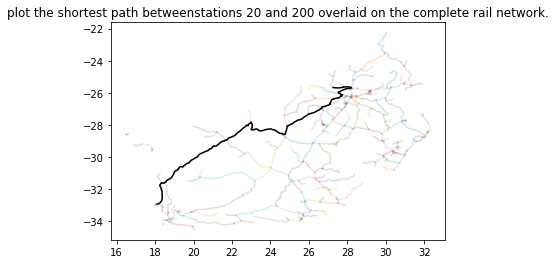

In [81]:
start = 20
end =200
results = shortestPath(graph, start, end)
paths= results[1]

for j in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][j].xy
    plt.plot(df['geometry'][j].xy[0], df['geometry'][j].xy[1], alpha = 0.2)
    for i in range(1,len(paths)):
        
        check = 0
        if np.sum([line_lats[0], line_lons[0]] == stations[paths[i],:])  == 2 and \
                np.sum([line_lats[-1], line_lons[-1]] == stations[paths[i-1],:])  == 2:
            check = 1
        if np.sum([line_lats[0], line_lons[0]] == stations[paths[i-1],:])  == 2 and \
                np.sum([line_lats[-1], line_lons[-1]] == stations[paths[i],:])  == 2:
            check = 1

                    #plt.plot(df['geometry'][j].xy[0], df['geometry'][i].xy[1],'k')
        if check == 1:
            plt.plot(df['geometry'][j].xy[0], df['geometry'][j].xy[1],c = 'k')
plt.title('plot the shortest path betweenstations 20 and 200 overlaid on the complete rail network.');

### User Interface

Station for facility?  Enter 1 to 457:100


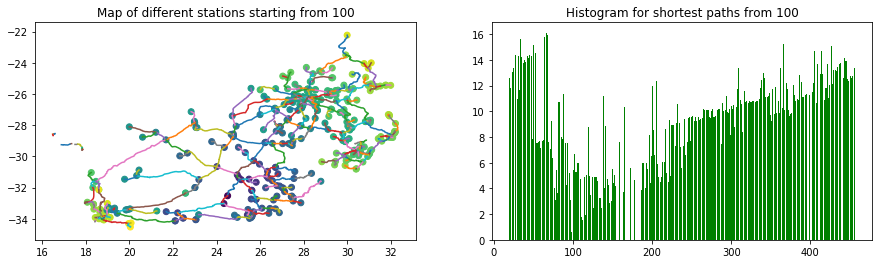

In [82]:
k = input('Station for facility?  Enter 1 to '+str(len(stations))+':')

dists = calculate_distances(graph, int(k))
type(dists)
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
for i in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])#,c = dists)
plt.scatter(stations[:,0],stations[:,1], c= list(dists.values()))#,alpha = 0.5);
plt.title('Map of different stations starting from {}'.format(k))
plt.subplot(122)
plt.bar(dists.keys(), dists.values(), color='g')
plt.title('Histogram for shortest paths from {}'.format(k));

Station for facility?  Enter 0 to 457:250


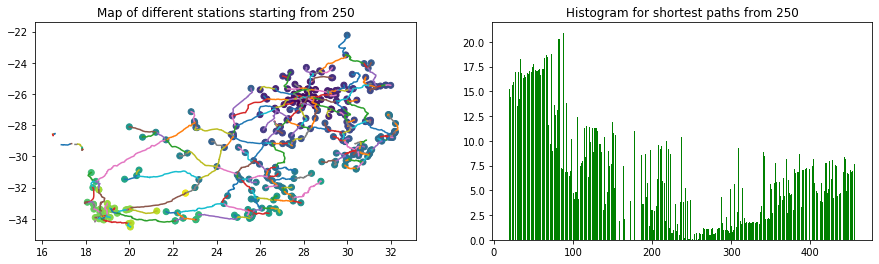

In [83]:
k = input('Station for facility?  Enter 0 to '+str(len(stations))+':')

dists = calculate_distances(graph, int(k))
type(dists)
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
for i in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])#,c = dists)
plt.scatter(stations[:,0],stations[:,1], c= list(dists.values()));#,alpha = 0.5);
plt.title('Map of different stations starting from {}'.format(k))
plt.subplot(122)
plt.bar(dists.keys(), dists.values(), color='g')
plt.title('Histogram for shortest paths from {}'.format(k));

Station for facility?  Enter 1 to 457:360


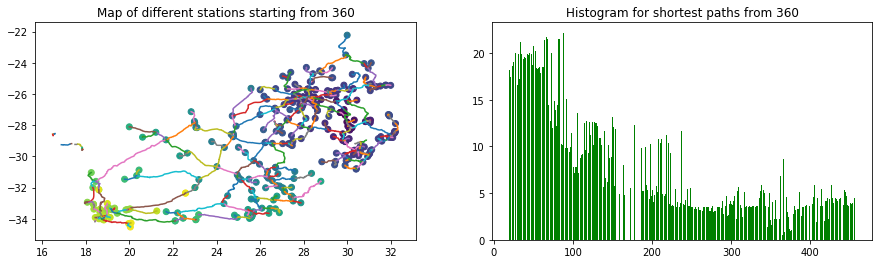

In [84]:
k = input('Station for facility?  Enter 1 to '+str(len(stations))+':')

dists = calculate_distances(graph, int(k))
type(dists)
fig = plt.figure(figsize=(15,4))
plt.subplot(121)
for i in range(len(df['geometry'])):
    line_lats, line_lons = df['geometry'][i].xy
    plt.plot(df['geometry'][i].xy[0], df['geometry'][i].xy[1])#,c = dists)
plt.scatter(stations[:,0],stations[:,1], c= list(dists.values()));#,alpha = 0.5);
plt.title('Map of different stations starting from {}'.format(k))
plt.subplot(122)
plt.bar(dists.keys(), dists.values(), color='g')
plt.title('Histogram for shortest paths from {}'.format(k));